In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from os import path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import datetime
import socket
import random
import easydict
from pytz import timezone
import operator
import pandas as pd

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from IPython.display import Image

import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline


In [3]:
tz = timezone('US/Eastern')

path = "/content/drive/MyDrive/D3data_allcont_3983/" # data directory

# train data
train_wo_file = "train_without_missing.txt"
train_w_file = "train_with_missing.txt"
train_meta = "train.meta"

# validation data
validation_wo_file = "validation_without_missing.txt"
validation_w_file = "validation_with_missing.txt"
validation_meta = "validation.meta"

# test data
test_wo_file = "test_without_missing.txt"
test_w_file = "test_with_missing.txt"
test_meta = "test.meta"

# checkpoint_epoch = 10
checkpoint = None

args = easydict.EasyDict({
    "log_name": "imputation_model",
    "model_type": "mlp",
    "nb_epochs":500,
    "bottleneck_dim":1024,
    "encoder_dim":6,
    "dencoder_dim":6,
    "encoder_dim":0,
    "dencoder_dim":0,
    "batch_size":64,
    "seq_len":3983,
    "learning_rate":0.00001,
    "betal":0.5,
    "seed":1,
    "missing_char":".",
    "resnet_mix":0.5,
    "optimizer":"adam",
    "haplotype_cutoff":1.0,
    "filter_size":7,
    "with_region_metadata":True,
    "continent": False,
    "save_model": True,
    "latent_dim":64,
    "gen_dim": 16,
    "disc_dim": 16,
    "gen_layers":1,
    "disc_layers": 1,
    "beta1": 0.5,
    "save_embedded_haplotypes": True,
    "vocab_size": 5,
    "train": True
})

os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = args.seed
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

charmap = {"A":0, "C":1, "G":2, "T":3, args.missing_char:4}
charmap_rev = {0:"A", 1:"C", 2:"G", 3:"T"}





Collect metadata info

In [4]:
df_train = pd.read_csv(path + train_meta, sep = '\t',header=None)
df_validation = pd.read_csv(path +validation_meta, sep='\t', header=None)
df_test = pd.read_csv(path+ test_meta, sep='\t', header=None)

In [5]:
df_train=df_train.fillna("NaN")
df_validation=df_validation.fillna("NaN")
df_test=df_test.fillna("NaN")

In [6]:
df_validation.head()

,0,1,2
0,ERR4243046,Europe,United Kingdom
1,ERR4085434,Europe,United Kingdom
2,SRR11621827,North America,USA
3,ERR4204618,Europe,United Kingdom
4,ERR4305040,Europe,United Kingdom


In [7]:
df_train[1].value_counts()

Europe           4817
Oceania           924
North America     872
Asia               88
Africa             87
Name: 1, dtype: int64

In [8]:
df_validation[1].value_counts()

Europe           1581
North America     315
Oceania           303
Africa             33
Asia               31
Name: 1, dtype: int64

In [9]:
df_test[1].value_counts()

Europe           1623
Oceania           294
North America     290
Africa             30
Asia               26
Name: 1, dtype: int64

In [10]:
countries = {region:i for i, region in enumerate(sorted(set(df_train[1])|set(df_validation[1])|set(df_test[1])))}
countries['NaN'] = len(countries) 
print(countries)

{'Africa': 0, 'Asia': 1, 'Europe': 2, 'North America': 3, 'Oceania': 4, 'NaN': 5}


In [11]:
if args.continent:
    meta_region = continents
else:
    meta_region = countries

In [12]:
def charmap_to_onehots(chars, charmap, model_type="resnet2d"):
    onehots = np.int_(np.zeros([len(chars),len(charmap)]))
    I = np.eye(len(charmap))
    for i, char in enumerate(chars):
        onehots[i] = I[charmap[char]]
        
    if model_type == "mlp":
        onehots = np.reshape(onehots, [-1])
    if model_type == "resnet1d" or model_type == "resnet2d":
        onehots = onehots.T
    return onehots

def metadata_to_one_hot(data, nb_classes, model_type = "resnet2d"):
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets].astype(int)[0]

def listToDict(lst):
    op = {lst[i].strip(): lst[i+1].strip() for i in range(0,len(lst), 2)}
    return op
        
    
# for GANs

def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

## Initiate the Dataset Class:

In [13]:
class CovidDataset(Dataset):
    def __init__(self, path, files, model, split="train", 
                 charmap=charmap, haplotype_cutoff=args.haplotype_cutoff, 
                 meta_continent=args.continent, meta_region=meta_region):
        """
        Args:
            :param path: path to dataset file
            :param file: dataset file name
            :param model: model of interest to work with
            :charmap: dict that maps nucleotides into digits which represet indexes of vectors in one-hot matrix
            ...
        """        
        self.dataset = {}
        for file in files[0]:
            with open(os.path.join(path, file), 'r') as f:
                content = f.readlines()
                templist = []
                for line in content:
                    seq_id, seq = line.strip().split("\t",1)
                    templist.append(seq_id)
                    templist.append(seq.replace("\t", ""))
                self.dataset = {**self.dataset, **listToDict(templist)}
                print("number of samples with duplication:", len(list(self.dataset.values())))
                print("number of samples without duplication:", len(set(list(self.dataset.values()))))
                #self.dataset = {**self.dataset, **listToDict(content)}
        self.dataset_new = {}
        for k, v in self.dataset.items(): # not including seq. with many miss. val. (based on haplotype_cutoff)
            if '.' in v:
                if v.count('.')/len(v) <= args.haplotype_cutoff: 
                    self.dataset_new[k] = v
            else:
                self.dataset_new[k] = v
        self.dataset = self.dataset_new
        #print(self.dataset)
        
        self.sequences = [charmap_to_onehots(sequence, charmap, model) for sequence in list(self.dataset.values())]
        self.ids = list(range(len(list(self.dataset))))
        
        index = 0
        if args.continent: index = 2 # for continent
        else: index = 1 # for country
            
        meta_place = {}        
        for file in files[1]:
            df = pd.read_csv(path + file, sep='\t', lineterminator='\n', header=None)
            df = df.fillna("NaN")
            meta_temp = {name:place for name, place in zip(list(df[0]), list(df[index]))}
            meta_place = {**meta_place, **meta_temp}
            
        self.meta_place = {}
        for i, name in enumerate(self.dataset):
            self.meta_place[i] = metadata_to_one_hot(meta_region[meta_place[name]], len(meta_region)+1)
            
    def __getitem__(self, i):
        id = self.ids[i]
        return self.sequences[id], self.meta_place[id]
    
    def __len__(self):
        return len(self.ids)

In [14]:
dataset_train = CovidDataset(path, [[train_w_file], [train_meta]], args.model_type)
dataset_validation = CovidDataset(path, [[validation_w_file], [validation_meta]], args.model_type)
dataset_test = CovidDataset(path, [[test_w_file], [test_meta]], args.model_type)

number of samples with duplication: 6788
number of samples without duplication: 5213
number of samples with duplication: 2263
number of samples without duplication: 1821
number of samples with duplication: 2263
number of samples without duplication: 1785


In [15]:
dataloader_train = DataLoader(dataset_train, args.batch_size, drop_last = True, shuffle = True)
dataloader_validation = DataLoader(dataset_validation, args.batch_size,drop_last=False,shuffle= False)
dataloader_test = DataLoader(dataset_test, args.batch_size,drop_last=False,shuffle= False)

In [16]:
len(dataloader_train)
# dataloader -> model -> criterion -> optimizer -> training loop

106

In [17]:
len(dataloader_validation)

36

In [18]:
examples = iter(dataloader_train)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([64, 19915]) torch.Size([64, 7])


In [19]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)


In [20]:

def save_models(logdir, generator, discriminator, true_count):
    """Function to save Denerator and Discriminator models (checkpointing)"""
    ckpt_dir = os.path.join(logdir, "checkpoints", "checkpoint_{}".format(true_count))
    os.makedirs(ckpt_dir, exist_ok=True)
    torch.save(generator.state_dict(), '{}/netG'.format(ckpt_dir))
    torch.save(discriminator.state_dict(), '{}/netD'.format(ckpt_dir))

# Model: Multi-Layer Perceptron

In [21]:
class mlp_generator(nn.Module):
    """ Multi-Layer Perceptron for generating sequences.

    Parameters:
        inputs (tensor):Batch of noises inputed to the network.
        dim (int):Generator dimension parameter (in each middle layer).
        input_size (int):Size of latent space (i.e., the first layer dimension).
        output_size (int):Size of the last layer (=max_seq_len*vocab_size).
        num_layers (int):How many middle or hidden layers for generator.

    Returns:
        outputs (tensor):Batch of lists of values (each `vocab_size` interval represents one nucleotide).   

    """
    def __init__(self, dim=64, input_size=19915, output_size=3, num_layers=4): # 5 x 3983
        super(mlp_generator, self).__init__()

        num_layers = num_layers + 2  # add 2 for the 1st and the last layers
        modules = []
        for layer in range(num_layers): 
            in_size = input_size if layer == 0 else dim
            out_size = output_size if layer == num_layers - 1 else dim
            if layer < num_layers - 1:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                        nn.ReLU(True),
                    )
                )
            else:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                        nn.Sigmoid()
                    )
                )
        self.layers = nn.Sequential(*modules)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

# rename to mlp_classifier
# outsize of disc = 17 (for countries)
class mlp_classifier(nn.Module):
    """ Multi-Layer Perceptron for discriminating real vs generated sequences.

    Parameters:
        inputs (tensor):Tensor of size (batch_size, vocab_size*max_seq_len) containing real or generated sequences.
        dim (int):Discriminator dimension parameter (in each middle layer).
        input_size (int):Size of the first layer (vocab_size*max_seq_len).
        num_layers (int):How many middle or hidden layers for discriminator.

    Returns:
        outputs (tensor):Batch of (single) values for real or generated inputs.   

    """
    def __init__(self, dim, input_size, num_layers=4):
        super(mlp_classifier, self).__init__()
        
        num_layers = num_layers + 2  # add 2 for the 1st and the last layers
        modules = []
        for layer in range(num_layers):
            in_size = input_size if layer == 0 else dim
            out_size = 5 if layer == num_layers - 1 else dim # if not last layer then uses dim size
            if layer < num_layers - 1:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                        nn.LeakyReLU(True),
                    )
                )
            else:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                    )
                )
        self.layers = nn.Sequential(*modules)
        
    def forward(self, inputs):
        inputs = inputs.view(inputs.size(0), -1)
        outputs = self.layers(inputs)
        return outputs

In [22]:
   
class resblock_2d(nn.Module):
    """Class to return a block of 2D Resudual Networks
    
    Parameters:
        inputs (tensor):Input of the previous layer
        num_channels (int):Dimension parameter (in each resnet block).
        network (str):Network of interest? 'discriminator' or 'generator' (slight 'relu' differentce in the results)
        kernel_size (tuple):Size of the (2D) filters (or kernels).

    Returns:
        outputs (torch.nn.Module):'resblock_2d' module that consist of several "conv2d->BN->relu" repetitions
    
    """
    def __init__(self, num_channels, network, kernel_size=(5, 3)):
        super(resblock_2d, self).__init__()
        modules = []
        if network=="generator":
            relu = nn.ReLU(True)
        elif network=="discriminator":
            relu = nn.ReLU(True)
        for r in range(2):
            modules.append(
                nn.Sequential(
                    nn.Conv2d(num_channels, num_channels, kernel_size, stride=(1, 1), 
                              padding=(kernel_size[0]//2, kernel_size[1]//2)),  # bottleneck: (batch, width, out_chan)
                    nn.BatchNorm2d(num_channels),
                    relu
                )
            )
        self.block = nn.Sequential(*modules)
        
    def forward(self, inputs):
        outputs = self.block(inputs)
        return outputs
    
class resnet_classifier_2d(nn.Module):
    """ Resudual Network with 2D convolutions for discriminating real vs generated sequences.

    Parameters:
        inputs (tensor):Tensor of size (batch_size, vocab_size, max_seq_len) containing real or generated sequences.
        num_channels (int):Discriminator dimension parameter (in each resnet block).
        vocab_size (int):Size of the first layer input channel.
        seq_len (int):Length of the input sequence.
        num_layers (int):How many repetitions of 'resblock_2d' for discriminator.

    Returns:
        outputs (tensor):Batch of 2D tensors of values in the size (vocab_size, seq_len).   

    """
    def __init__(self, num_channels, vocab_size, seq_len, res_layers=5):
        super(resnet_classifier_2d, self).__init__()
        
        self.num_channels = num_channels
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.res_layers = res_layers
                
        self.conv = nn.Sequential(
                nn.Conv2d(1, num_channels, (3, 1), stride=(1, 1), padding=(3//2, 0))  # (batch, width, out_chan)
            )
        resblocks = []
        for i in range(res_layers):
            resblocks.append(resblock_2d(self.num_channels, "discriminator"))
        self.resblocks = nn.Sequential(*resblocks)
        self.prediction_layer = nn.Linear(self.vocab_size*seq_len*num_channels, 5)
            
    def forward(self, inputs):
        inputs = torch.reshape(inputs, [-1, 1, self.vocab_size, self.seq_len])
        outputs = self.conv(inputs)
        inputs = outputs
        for i in range(self.res_layers):
            outputs = 1.0*self.resblocks[i](inputs) + inputs  # where resnet idea comes into play!
            inputs = outputs
        outputs = torch.reshape(outputs, [-1, self.vocab_size*self.seq_len*self.num_channels])
        
        outputs = self.prediction_layer(outputs)
        return outputs

# Criterion + Optimizer:

In [23]:
vocab_size = 5# instantiate models
if args.model_type=="mlp":
   # netC = mlp_classifier(args.gen_dim, args.latent_dim, args.seq_len*args.vocab_size, args.gen_layers).to(device)
  #  netD = mlp_discriminator(args.disc_dim, args.seq_len*vocab_size, args.disc_layers).to(device) #fix max_seq_len
    model = mlp_classifier(args.disc_dim, args.seq_len*vocab_size, args.disc_layers).to(device)
if args.model_type=="resnet2d":
    model = resnet_classifier_2d(args.disc_dim, vocab_size, args.seq_len, args.disc_layers).to(device)
print("test")
print("{}\nClassifier Network Architecture:\n{}\n{}\n".format("="*31, "~"*31, model))
# print("{}\nDiscriminator Network Architecture:\n{}\n{}\n".format("="*35, "~"*35, netD))

# cost function (for discriminator prediction)
# criterion = nn.BCEWithLogitsLoss() # use CE loss for classifier
criterion = nn.CrossEntropyLoss()

# setup optimizer
# optimizerG = optim.Adam(list(netG.parameters()), lr=args.learning_rate)
# optimizerD = optim.Adam(list(netD.parameters()), lr=args.learning_rate)
optimizerM = optim.Adam(list(model.parameters()), lr=args.learning_rate, betas=(args.beta1, 0.999))


test
Classifier Network Architecture:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mlp_classifier(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=19915, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=True)
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=True)
    )
    (2): Sequential(
      (0): Linear(in_features=16, out_features=5, bias=True)
    )
  )
)



# Training Loop + Metrics:

In [24]:
es = EarlyStopping(patience=5)
epochs = args.nb_epochs
steps = 0
running_loss = 0
print_every = 10
train_losses, validation_losses = [], []
train_accuracies, valid_accuracies = [], []
for epoch in range(epochs):
    correct = 0
    total = 0
    for inputs, labels in dataloader_train:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizerM.zero_grad()
        logps = model.forward(inputs.float())
        #print(logps.shape)
        loss = criterion(logps, torch.argmax(labels, 1))
        loss.backward()
        optimizerM.step()
        running_loss += loss.item()*inputs.shape[0]
        for pred, true in zip(torch.argmax(logps, 1), torch.argmax(labels, 1)):
            if pred == true: correct += 1
            total += 1

    train_accuracy = np.round((correct/total)*100, 3) 

    #if steps % print_every == 0:
    validation_loss = 0
    accuracy = 0
    MAX_VAL=0
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in dataloader_validation:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs.float())
            #print(logps)
            batch_loss = criterion(logps, torch.argmax(labels, 1))
            validation_loss += batch_loss.item()*inputs.shape[0]

            for pred, true in zip(torch.argmax(logps, 1), torch.argmax(labels, 1)):
                if pred == true: correct += 1
                total += 1
        validation_accuracy = np.round((correct/total)*100, 3)


        train_losses.append(running_loss/len(dataset_train))
        validation_losses.append(validation_loss/len(dataset_validation))
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(validation_accuracy)   
        

                           
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train loss: {running_loss/len(dataset_train):.5f} | "
              f"validation loss: {validation_loss/len(dataset_validation):.5f} | "
              f"train accuracy: {train_accuracy}% | " 
              f"validation accuracy: {validation_accuracy}%")
        running_loss = 0
        model.train()
#        metric = eval(model, dataloader_test)
#        if es.step(metric):
#                break  # early stop criterion is met, we can stop now
torch.save(model.state_dict(), "/content/drive/MyDrive/classifier_test.pth")

Epoch 1/500 | Train loss: 1.01177 | validation loss: 0.90738 | train accuracy: 70.814% | validation accuracy: 69.863%
Epoch 2/500 | Train loss: 0.84846 | validation loss: 0.84369 | train accuracy: 70.976% | validation accuracy: 69.863%
Epoch 3/500 | Train loss: 0.79995 | validation loss: 0.80718 | train accuracy: 71.02% | validation accuracy: 70.217%
Epoch 4/500 | Train loss: 0.76636 | validation loss: 0.77653 | train accuracy: 71.742% | validation accuracy: 71.233%
Epoch 5/500 | Train loss: 0.74086 | validation loss: 0.75327 | train accuracy: 72.759% | validation accuracy: 72.647%
Epoch 6/500 | Train loss: 0.71898 | validation loss: 0.73390 | train accuracy: 74.086% | validation accuracy: 73.177%
Epoch 7/500 | Train loss: 0.70186 | validation loss: 0.72043 | train accuracy: 75.118% | validation accuracy: 73.752%
Epoch 8/500 | Train loss: 0.68686 | validation loss: 0.70426 | train accuracy: 75.914% | validation accuracy: 75.033%
Epoch 9/500 | Train loss: 0.67408 | validation loss: 0.69

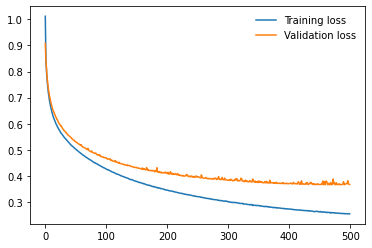

In [25]:
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

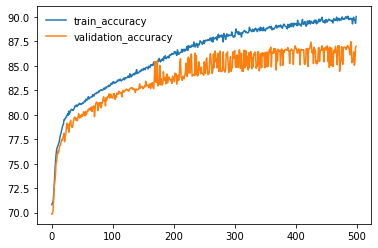

In [26]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(valid_accuracies, label='validation_accuracy')
plt.legend(frameon=False)
plt.show()

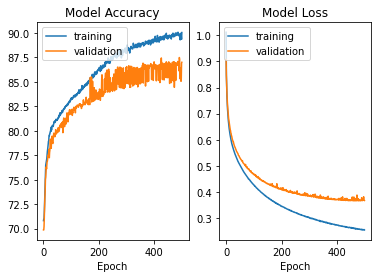

In [27]:

# plot together
plt.ion()
fig = plt.figure()
subfig = fig.add_subplot(121)
subfig.plot(train_accuracies, label="training")
subfig.plot(valid_accuracies, label="validation")
subfig.set_title('Model Accuracy')
subfig.set_xlabel('Epoch')
subfig.legend(loc='upper left')
subfig = fig.add_subplot(122)
subfig.plot(train_losses, label="training")
subfig.plot(validation_losses, label="validation")
subfig.set_title('Model Loss')
subfig.set_xlabel('Epoch')
subfig.legend(loc='upper left')
plt.ioff()

In [28]:
predictions = [] # instead of correct
targets = [] # instead of total
for inputs, labels in dataloader_test:
    inputs, labels = inputs.to(device), labels.to(device)
    preds = model.eval()(inputs.float())
    predictions.extend(torch.argmax(preds, 1).tolist())
    targets.extend(torch.argmax(labels, 1).tolist())
print(classification_report(targets, predictions, labels=list(set(targets))))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75        30
           1       0.75      0.58      0.65        26
           2       0.91      0.95      0.93      1623
           3       0.67      0.69      0.68       290
           4       0.91      0.69      0.78       294

    accuracy                           0.87      2263
   macro avg       0.85      0.70      0.76      2263
weighted avg       0.87      0.87      0.87      2263



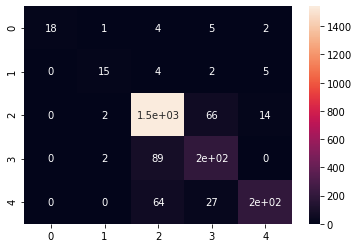

In [29]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(targets, predictions))

sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
# 

In [ ]:
model_test =torch.load("/content/drive/MyDrive/model.pth")
model_test.eval()


FileNotFoundError: ignored

In [ ]:
dataiter = iter(dataloader_test)
sequences, labels = dataiter.next()

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(17)))

NameError: ignored

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

NameError: ignored

## Ignore all below, old code!

In [ ]:
nb_epochs = args.nb_epochs
def train(epoch):
    n = 0
    for epoch in range(nb_epochs):
        for seqs, labels in iter(dataloader_train):
            print("step 1")
            zs = model(seqs.float())
            print("completed  model")
            loss = criterion(zs, labels) # computes total loss
            print("computed loss")
            loss.backward() # compute updates for each parameter
            print("updated")
            optimizer.step() # make the updates for each param.
            optimizer.zero_grad() # clean up step 
            print(epoch)
        
            n += 1 
    
    return model

In [ ]:
test = train(10)

In [ ]:
seqs, labels = next(iter(dataloader_train))

In [ ]:
print(seqs.shape)
print(labels.shape)

## Disregard the code under (old stuff):

In [ ]:
seqs, labels = next(iter(dataloader_train))

In [ ]:
print(labels.shape)

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=685, im_dim=685, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)
    
class Discriminator(nn.Module):
    def __init__(self, im_dim=685, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)
    

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=args.learning_rate)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=args.learning_rate)

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
for epoch in range(args.nb_epochs):
  
    # Dataloader returns the batches
    for real in dataloader_train:
        cur_batch_size = len(real)
        print(real.shape)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        
        print(epoch)
        
        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

In [ ]:
print(args.nb_epochs)

In [ ]:
class mlp_generator(nn.Module):
    """ Multi-Layer Perceptron for generating sequences.

    Parameters:
        inputs (tensor):Batch of noises inputed to the network.
        dim (int):Generator dimension parameter (in each middle layer).
        input_size (int):Size of latent space (i.e., the first layer dimension).
        output_size (int):Size of the last layer (=max_seq_len*vocab_size).
        num_layers (int):How many middle or hidden layers for generator.

    Returns:
        outputs (tensor):Batch of lists of values (each `vocab_size` interval represents one nucleotide).   

    """
    def __init__(self, dim=200, input_size=100, output_size=10, num_layers=4):
        super(mlp_generator, self).__init__()

        num_layers = num_layers + 2  # add 2 for the 1st and the last layers
        modules = []
        for layer in range(num_layers): 
            in_size = input_size if layer == 0 else dim
            out_size = output_size if layer == num_layers - 1 else dim
            if layer < num_layers - 1:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                        nn.ReLU(True),
                    )
                )
            else:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                        nn.Sigmoid()
                    )
                )
        self.layers = nn.Sequential(*modules)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x


class mlp_discriminator(nn.Module):
    """ Multi-Layer Perceptron for discriminating real vs generated sequences.

    Parameters:
        inputs (tensor):Tensor of size (batch_size, vocab_size*max_seq_len) containing real or generated sequences.
        dim (int):Discriminator dimension parameter (in each middle layer).
        input_size (int):Size of the first layer (vocab_size*max_seq_len).
        num_layers (int):How many middle or hidden layers for discriminator.

    Returns:
        outputs (tensor):Batch of (single) values for real or generated inputs.   

    """
    def __init__(self, dim, input_size, num_layers=4):
        super(mlp_discriminator, self).__init__()
        
        num_layers = num_layers + 2  # add 2 for the 1st and the last layers
        modules = []
        for layer in range(num_layers):
            in_size = input_size if layer == 0 else dim
            out_size = 1 if layer == num_layers - 1 else dim
            if layer < num_layers - 1:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                        nn.LeakyReLU(0.2, inplace=True),
                    )
                )
            else:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                    )
                )
        self.layers = nn.Sequential(*modules)
        
    def forward(self, inputs):
        inputs = inputs.view(inputs.size(0), -1)
        outputs = self.layers(inputs)
        return outputs


In [ ]:
# instantiate models
if args.model_type=="mlp":
    netG = mlp_generator(args.gen_dim, args.latent_dim, args.max_seq_len*vocab_size, args.gen_layers).to(device)
    netD = mlp_discriminator(args.disc_dim, args.max_seq_len*vocab_size, args.disc_layers).to(device)
elif args.model_type=="resnet1d":
    netG = resnet_generator_1d(args.gen_dim, args.latent_dim, vocab_size, args.max_seq_len, args.gen_layers).to(device)
    netD = resnet_discriminator_1d(args.disc_dim, vocab_size, args.max_seq_len, args.disc_layers).to(device)
elif args.model_type=="resnet2d":
    netG = resnet_generator_2d(args.gen_dim, args.latent_dim, vocab_size, args.max_seq_len, args.gen_layers).to(device)
    netD = resnet_discriminator_2d(args.disc_dim, vocab_size, args.max_seq_len, args.disc_layers).to(device)

print("{}\nGenerator Network Architecture:\n{}\n{}\n".format("="*31, "~"*31, netG))
print("{}\nDiscriminator Network Architecture:\n{}\n{}\n".format("="*35, "~"*35, netD))

# cost function (for discriminator prediction)
criterion = nn.BCEWithLogitsLoss()

# setup optimizer
optimizerG = optim.Adam(list(netG.parameters()), lr=args.learning_rate, betas=(args.beta1, 0.999))
optimizerD = optim.Adam(list(netD.parameters()), lr=args.learning_rate, betas=(args.beta1, 0.999))

# use an exponentially decaying learning rate
schedulerG = optim.lr_scheduler.ExponentialLR(optimizerG, gamma=0.99)
schedulerD= optim.lr_scheduler.ExponentialLR(optimizerD, gamma=0.99)